In [1]:
from os import listdir
from os.path import isfile, join, isdir
import numpy as np
from PIL import Image
from tqdm import tqdm
import keras
from keras.layers import Conv2DTranspose, ConvLSTM2D, BatchNormalization, TimeDistributed, Conv2D,LayerNormalization
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt

In [2]:
class Config:
    DATASET_PATH = "E:/ASEB/3rd Year/Maths/End Sem Final/extracted_frames/training"
    SINGLE_TEST_PATH = "E:/ASEB/3rd Year/Maths/End Sem/extracted_frames/test_extracted/8"
    BATCH_SIZE = 4
    EPOCHS = 3
    MODEL_PATH = "E:/ASEB/3rd Year/Maths/End Sem Final/model.hdf5"

In [3]:
def get_clips_by_stride(stride, frames_list, sequence_size):
    clips = []
    sz = len(frames_list)
    clip = np.zeros(shape=(sequence_size, 256, 256, 3))  # Adjust the shape to handle RGB images
    cnt = 0
    for start in range(0, stride):
        for i in range(start, sz, stride):
            clip[cnt, :, :, :] = frames_list[i]  # Keep all three channels
            cnt = cnt + 1
            if cnt == sequence_size:
                clips.append(np.copy(clip))
                cnt = 0
    return clips


def get_training_set():
    clips = []
    # loop over the training folders (Train000, Train001, ...)
    for f in tqdm(sorted(listdir(Config.DATASET_PATH)), desc='Loading Training Set'):
        directory_path = join(Config.DATASET_PATH, f)
        if isdir(directory_path):
            all_frames = []
            # loop over all the images in the folder (0.tif, 1.tif, ..., 199.tif)
            for c in sorted(listdir(directory_path)):
                img_path = join(directory_path, c)
                if str(img_path)[-3:].lower() == "png":
                    img = Image.open(img_path).resize((256, 256))
                    img = np.array(img, dtype=np.float32) / 256.0
                    all_frames.append(img)
            # get the 10-frame sequences from the list of images after applying data augmentation
            for stride in range(1, 3):
                clips.extend(get_clips_by_stride(stride=stride, frames_list=all_frames, sequence_size=7))
    return clips


In [4]:
def get_model(reload_model=True):
    if not reload_model:
        return load_model(Config.MODEL_PATH, custom_objects={'LayerNormalization': LayerNormalization})
    
    training_set = get_training_set()
    training_set = np.array(training_set)
    
    seq = Sequential()
    seq.add(TimeDistributed(Conv2D(128, (11, 11), strides=4, padding="same"), batch_input_shape=(None, 7, 256, 256, 3)))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(32, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(ConvLSTM2D(64, (3, 3), padding="same", return_sequences=True))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(64, (5, 5), strides=2, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2DTranspose(128, (11, 11), strides=4, padding="same")))
    seq.add(LayerNormalization())
    seq.add(TimeDistributed(Conv2D(1, (11, 11), activation="sigmoid", padding="same")))
    print(seq.summary())
    seq.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, beta_2=0.999, epsilon=1e-6))
    seq.fit(training_set, training_set, batch_size=Config.BATCH_SIZE, epochs=Config.EPOCHS, shuffle=False)
    seq.save(Config.MODEL_PATH)
    return seq

In [5]:
def get_single_test():
    test_frames = [f for f in sorted(listdir(Config.SINGLE_TEST_PATH)) if f.lower().endswith(".png")]

    sz = len(test_frames)
    test = np.zeros(shape=(sz, 256, 256, 3))
    cnt = 0

    for f in test_frames:
        img = Image.open(join(Config.SINGLE_TEST_PATH, f)).resize((256, 256))
        img = np.array(img, dtype=np.float32) / 256.0
        test[cnt, :, :, :] = img
        cnt += 1

    return test


In [6]:
def evaluate():
    model = get_model(False)
    print("got model")
    test = get_single_test()
    print("got test")
    sz = test.shape[0]
    sequence_size = 7  # Set the desired sequence size
    sequences = []
    anomaly_frames = []  # List to store the names of anomaly frames

    # Create sequences of the specified size
    for i in range(0, sz - sequence_size + 1):
        clip = np.zeros((sequence_size, 256, 256, 3))  # Keep 3 channels for RGB
        for j in range(0, sequence_size):
            clip[j] = test[i + j, :, :, :]  # Keep all channels for RGB
        sequences.append(np.copy(clip))

    # Convert the list of sequences to a numpy array
    sequences = np.array(sequences)

    # Get the reconstruction cost of all the sequences
    reconstructed_sequences = model.predict(sequences, batch_size=4)

    # Reshape the sequences and reconstructions
    sequences_flat = sequences.reshape((-1,) + sequences.shape[2:])
    reconstructed_flat = reconstructed_sequences.reshape((-1,) + reconstructed_sequences.shape[2:])

    # Calculate the reconstruction cost
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences_flat[i], reconstructed_flat[i])) for i in range(sequences_flat.shape[0])])

    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / np.max(sequences_reconstruction_cost)
    sr = 1.0 - sa

    # Set a dynamic threshold based on the mean and standard deviation of the regularity scores
    threshold = np.mean(sr) + 1.5* np.std(sr)  # Adjust the multiplier (2.5 in this case) based on your requirement

    # Print the names of frames detected as anomalies
    for i in range(sr.shape[0]):
        if sr[i] < threshold:  # Adjust threshold based on your requirement
            anomaly_frames.append(f"Frame {i + sequence_size - 1}")  # Append the name of the frame

    # Plot the regularity scores
    plt.figure(figsize=(25, 5))  # Adjust the figure size as needed
    plt.plot(sr)
    plt.axhline(y=threshold, color='r', linestyle='--', label='Dynamic Threshold')
    plt.ylabel('regularity score Sr(t)')
    plt.xlabel('frame t')
    plt.xticks(np.arange(0, sr.shape[0], step=25))  # Adjust the step value as needed
    plt.legend()
    plt.show()

    # Print the names of anomaly frames
    print("Anomaly Frames:", anomaly_frames)

In [51]:
model = get_model(True)  # Set True to train a new one or False to reload existing model 

Loading Training Set:   0%|          | 0/16 [00:00<?, ?it/s]

Loading Training Set: 100%|██████████| 16/16 [00:27<00:00,  1.74s/it]


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_10 (TimeD  (None, 7, 64, 64, 128)    46592     
 istributed)                                                     
                                                                 
 layer_normalization_14 (La  (None, 7, 64, 64, 128)    256       
 yerNormalization)                                               
                                                                 
 time_distributed_11 (TimeD  (None, 7, 32, 32, 64)     204864    
 istributed)                                                     
                                                                 
 layer_normalization_15 (La  (None, 7, 32, 32, 64)     128       
 yerNormalization)                                               
                                                                 
 conv_lstm2d_6 (ConvLSTM2D)  (None, 7, 32, 32, 64)    



got model
got test
8/8 [==============================] - 27s 3s/step


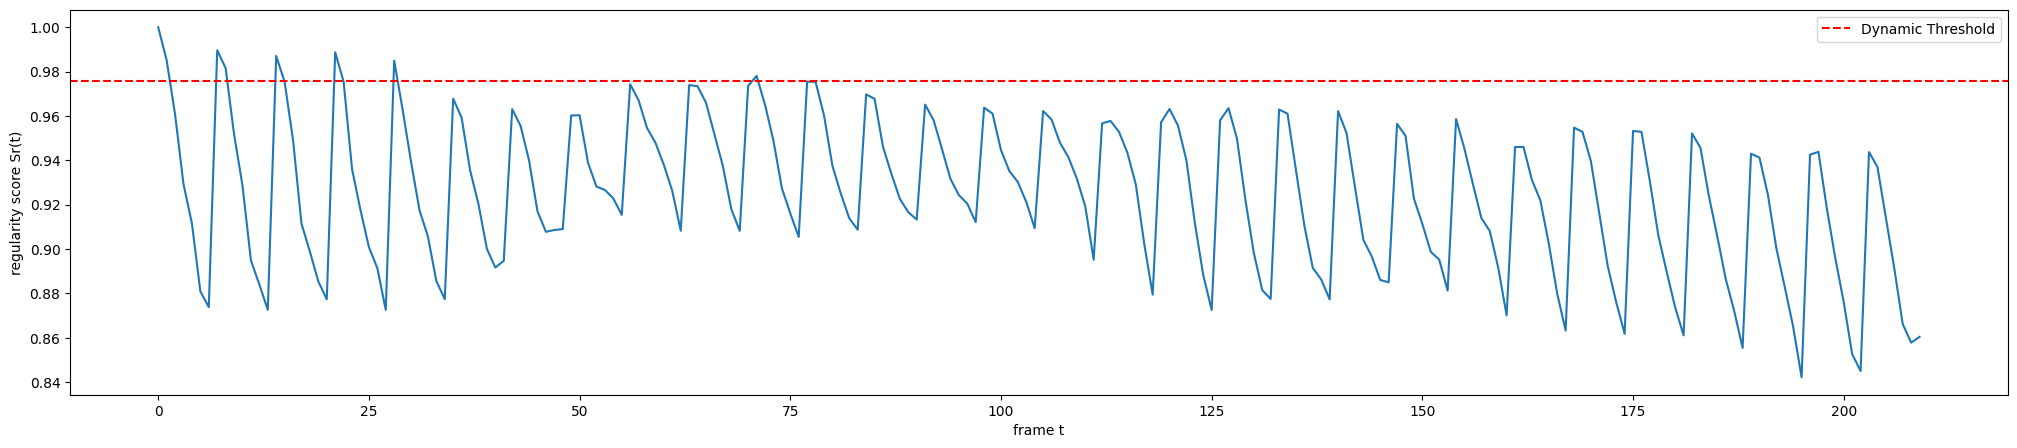

Anomaly Frames: ['Frame 8', 'Frame 9', 'Frame 10', 'Frame 11', 'Frame 12', 'Frame 15', 'Frame 16', 'Frame 17', 'Frame 18', 'Frame 19', 'Frame 21', 'Frame 22', 'Frame 23', 'Frame 24', 'Frame 25', 'Frame 26', 'Frame 28', 'Frame 29', 'Frame 30', 'Frame 31', 'Frame 32', 'Frame 33', 'Frame 35', 'Frame 36', 'Frame 37', 'Frame 38', 'Frame 39', 'Frame 40', 'Frame 41', 'Frame 42', 'Frame 43', 'Frame 44', 'Frame 45', 'Frame 46', 'Frame 47', 'Frame 48', 'Frame 49', 'Frame 50', 'Frame 51', 'Frame 52', 'Frame 53', 'Frame 54', 'Frame 55', 'Frame 56', 'Frame 57', 'Frame 58', 'Frame 59', 'Frame 60', 'Frame 61', 'Frame 62', 'Frame 63', 'Frame 64', 'Frame 65', 'Frame 66', 'Frame 67', 'Frame 68', 'Frame 69', 'Frame 70', 'Frame 71', 'Frame 72', 'Frame 73', 'Frame 74', 'Frame 75', 'Frame 76', 'Frame 78', 'Frame 79', 'Frame 80', 'Frame 81', 'Frame 82', 'Frame 83', 'Frame 84', 'Frame 85', 'Frame 86', 'Frame 87', 'Frame 88', 'Frame 89', 'Frame 90', 'Frame 91', 'Frame 92', 'Frame 93', 'Frame 94', 'Frame 95', '

In [7]:
evaluate()